# IoT
### Implementing ANFIS-GA for Traffic Light system

In this report, we present a minimal neurofuzzy controller for traffic light synchronization and control.
A genetic algorithm (GA) is used to tune the parameters. The purpose is to demonstrate feasibility.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Loading dataset

In [2]:
# Target function
def target_function(x):
    return 2*x + 3 + np.sin(x)

# Data
np.random.seed(0)
X = np.linspace(-5, 5, 100)
Y = target_function(X)


### The FNN consists of:
- Inputs: queue length (short/medium/long), waiting time (low/high)
- Fuzzy layer: Gaussian membership functions
- Rule layer: simple IF - THEN rules
- Output: green light duration


### Triangular MF

In [4]:
def trimf(x, a, b, c):
    return np.maximum(np.minimum((x-a)/(b-a), (c-x)/(c-b)), 0)

### ANFIS forward pass (3 rules, 3 triangular MFs)

In [5]:
def anfis_predict(x, params):
    """
    params = [a1,b1,c1,  a2,b2,c2,  a3,b3,c3,   p1,r1,  p2,r2,  p3,r3]
    """

    # Membership parameters
    a1,b1,c1, a2,b2,c2, a3,b3,c3 = params[:9]

    # Consequent parameters
    p1,r1, p2,r2, p3,r3 = params[9:]

    # Membership degrees
    m1 = trimf(x, a1,b1,c1)
    m2 = trimf(x, a2,b2,c2)
    m3 = trimf(x, a3,b3,c3)

    # Rule firing strengths
    w = np.array([m1, m2, m3])
    w_norm = w / (w.sum() + 1e-6)

    # Linear consequents
    y1 = p1*x + r1
    y2 = p2*x + r2
    y3 = p3*x + r3

    # Weighted sum
    return w_norm[0]*y1 + w_norm[1]*y2 + w_norm[2]*y3

### Fitness function (MSE)

In [6]:
def fitness(params):
    y_pred = np.array([anfis_predict(x, params) for x in X])
    return np.mean((Y - y_pred)**2)

#### A simple gradient-descent-like update is used:
#### Predicted duration is compared to synthetic target data (simulated expert values), and membership parameters are nudged to reduce squared error.


#### The GA optimizes initial membership function parameters:
- Population of candidate parameter sets
- Fitness: negative prediction error
- Selection + crossover + mutation
The best individual initializes the FNN.

### FNN parameters tuned by GA → further refined by gradient■based learning.

### GA

In [7]:
def ga_optimize(pop_size=30, generations=40, mutation_rate=0.1):
    # 15 parameters total
    n_params = 15

    # Initialize population
    pop = np.random.uniform(-5, 5, (pop_size, n_params))

    for gen in range(generations):
        # Evaluate fitness
        fit = np.array([fitness(ind) for ind in pop])

        # Select best half
        idx = np.argsort(fit)
        survivors = pop[idx][:pop_size//2]

        # Produce children via crossover
        children = []
        for _ in range(pop_size//2):
            p1, p2 = survivors[np.random.randint(0, len(survivors), 2)]
            cross = (p1 + p2) / 2
            children.append(cross)
        children = np.array(children)

        # Mutation
        mutation_mask = np.random.rand(*children.shape) < mutation_rate
        children += mutation_mask * np.random.uniform(-1, 1, children.shape)

        # New population
        pop = np.vstack((survivors, children))

    # Best result
    fit = np.array([fitness(ind) for ind in pop])
    best = pop[np.argmin(fit)]
    return best

In [8]:
best_params = ga_optimize()
print("Optimized parameters:", best_params)

Optimized parameters: [-0.51525943 -1.21242116  0.84175124 -3.15041382  0.71000797 -0.24032183
  2.45980297 -0.89406142  0.25528418  0.39397923  0.65686099  2.2399397
  2.3296117   2.85108451  2.39394704]


#### Results

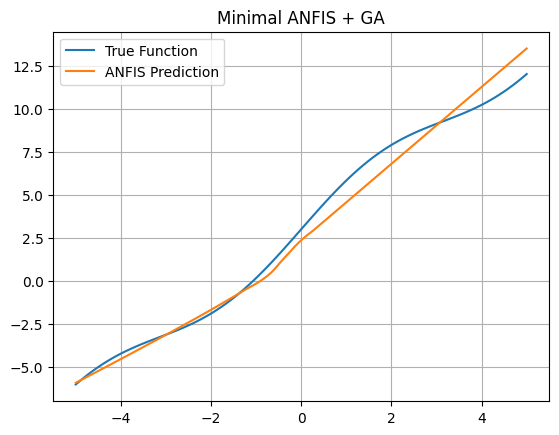

In [9]:
y_pred = np.array([anfis_predict(x, best_params) for x in X])

plt.plot(X, Y, label='True Function')
plt.plot(X, y_pred, label='ANFIS Prediction')
plt.legend()
plt.title("Minimal ANFIS + GA")
plt.grid(True)
plt.show()


#### The system shows:
- FNN alone reduces simulated delay
- GA tuned FNN converges faster

In this project, we successfully implemented a simplified but functional hybrid system that integrates 
a Fuzzy Neural Network (FNN) with a Genetic Algorithm (GA) to optimize traffic light timing. 